### Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Importando Base de Dados

In [2]:
#load data from txt file with no head witch the data is splot by :::
data = pd.read_table('/content/gdrive/MyDrive/Genre_Classification_Dataset/train_data.txt', sep=':::', engine='python',header=None)
#remove index 
data = data.drop([0], axis=1)
#set dataframe head 
data.columns = ['name', 'genre','description']

### ETL

In [3]:
#removing whitespaces from the start and end of the colum "genre"
data['genre'] = data['genre'].str.strip()

In [4]:
print("before filtering genres: ",len(data))
filter_list = ['drama', 'comedy', 'horror', 'thriller', 'action', 'mystery', 'sci-fi', 'fantasy', 'western', 'romance', 'music']
data = data[data['genre'].isin(filter_list)]
print("after filtering genres: ",len(data))

before filtering genres:  54214
after filtering genres:  29894


Vamo ver se a gente vai usar isso, talvez tentar primeiro sem:

In [5]:
#creating a "super-genre" out of "horror", "thriller" and "mystery" 
data['genre'] = data['genre'].replace(['horror', 'thriller', 'mystery'], 'h-t-m')

#creating a "super-genre" out of "sci-fi" and "fantasy"
data['genre'] = data['genre'].replace(['sci-fi', 'fantasy'], 's-f')

#reindex data
data = data.reset_index(drop=True)

<ipython-input-5-ec25735b02ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['genre'] = data['genre'].replace(['horror', 'thriller', 'mystery'], 'h-t-m')
<ipython-input-5-ec25735b02ca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['genre'] = data['genre'].replace(['sci-fi', 'fantasy'], 's-f')


In [6]:
#removendo possiveis valores nulos de descrição
data = data[data['description'].notna()]

### EDA

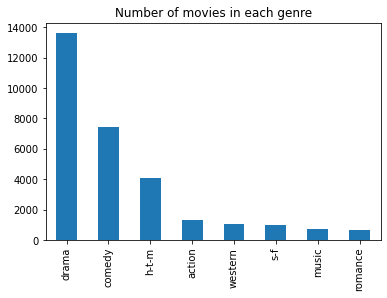

In [7]:
#ploting the number of movies in each genre
data['genre'].value_counts().plot(kind='bar', title='Number of movies in each genre')

### Construção da Matriz TF-IDF

In [8]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 16.1 MB/s 


In [9]:
import nltk
from nltk import word_tokenize
import string
import unidecode
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')


listStringTerms = []


def criandoLinha(descrição):
    #capturando tokens da descrição
    tokens = word_tokenize(descrição)
    #normalizando para minúsculo
    tokens = [w.lower() for w in tokens]


    #removendo simbolos de pontuação
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]



    #tratando caracteres especiais
    tokens = [unidecode.unidecode(w) for w in tokens]

    #selecionando apenas palavras
    words = [word for word in tokens if word.isalpha()]

    #removendo palavras com 3 ou menos caracteres
    words = [word for word in words if len(word) > 3]
    
    #removendo palavras vazias
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]


    #redução de palavras
    porter = PorterStemmer()
    stemmedWords = [porter.stem(word) for word in words] 

    #transformando lista de stemmedWords em uma string
    stringTerms = ' '.join(stemmedWords)



    return stringTerms



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
#criando a lista de strings de termos
listStringTerms = data['description'].apply(criandoLinha)

In [11]:
##construindo matriz TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df = 0.70, min_df = 0.05)
X = vectorizer.fit_transform(listStringTerms)
X

<29894x111 sparse matrix of type '<class 'numpy.float64'>'
	with 289000 stored elements in Compressed Sparse Row format>

In [12]:
#save X and y in a file
with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)

In [13]:
X = pickle.load(open('X.pickle', 'rb'))

In [14]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=6, random_state=3)
X_svd = svd.fit_transform(X)

In [15]:
svd.explained_variance_ratio_.sum()

0.10318093909317558

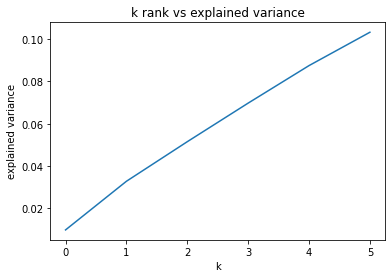

In [16]:
#plot k rank vs explained variance
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('k')
plt.ylabel('explained variance')
plt.title('k rank vs explained variance')
plt.show()


In [17]:
data['genre']

0         drama
1         h-t-m
2         drama
3         drama
4        comedy
          ...  
29889     music
29890     drama
29891    comedy
29892     h-t-m
29893    comedy
Name: genre, Length: 29894, dtype: object

### Agrupamento

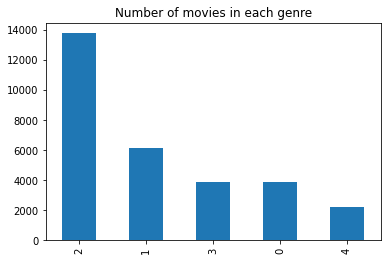

In [18]:
#k means classifier for X_svd
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=45).fit(X_svd)
y_kmeans = kmeans.predict(X_svd)

#ploting the number of movies in each genre
pd.Series(y_kmeans).value_counts().plot(kind='bar', title='Number of movies in each genre')

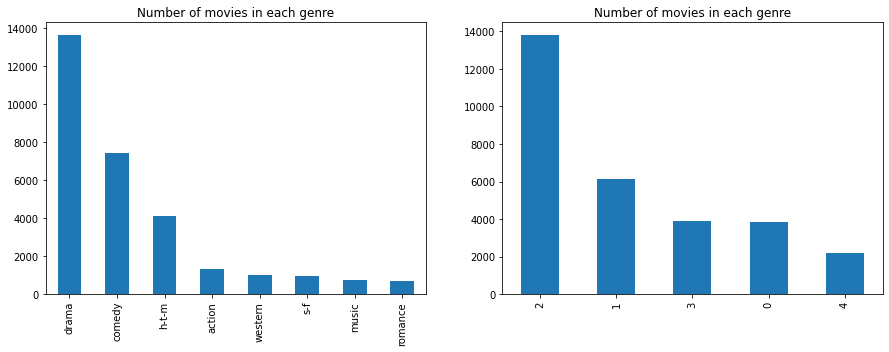

In [19]:
#plot both count plots of genre on top of each other
fig, ax = plt.subplots(1,2, figsize=(15,5))
data['genre'].value_counts().plot(kind='bar', title='Number of movies in each genre', ax=ax[0])
pd.Series(y_kmeans).value_counts().plot(kind='bar', title='Number of movies in each genre', ax=ax[1])
plt.show()

In [20]:
#create a dataframe with y_kmeans
y_kmeans_df = pd.DataFrame(y_kmeans, columns=['genre'])
values_counts = pd.Series(y_kmeans).value_counts()
values_counts

2    13790
1     6136
3     3897
0     3861
4     2210
dtype: int64

### Agrupamento Hierárquico


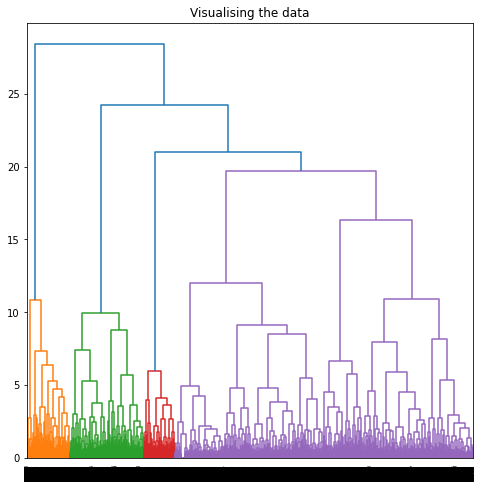

In [21]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize =(8, 8))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_svd, method ='ward')))

In [22]:
from sklearn.cluster import AgglomerativeClustering

m = AgglomerativeClustering(n_clusters = 6, linkage = 'average')
m.fit(X_svd)

AgglomerativeClustering(linkage='average', n_clusters=6)

In [23]:
#m.labels_
np.unique(m.labels_)


array([0, 1, 2, 3, 4, 5])

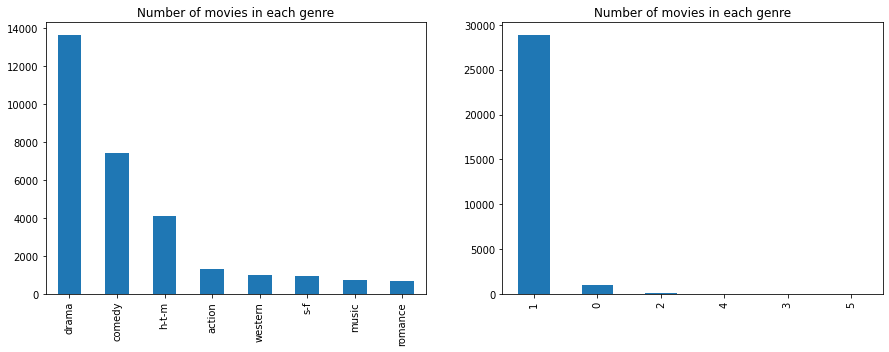

In [24]:
#plot both count plots of genre on top of each other
fig, ax = plt.subplots(1,2, figsize=(15,5))
data['genre'].value_counts().plot(kind='bar', title='Number of movies in each genre', ax=ax[0])
pd.Series(m.labels_).value_counts().plot(kind='bar', title='Number of movies in each genre', ax=ax[1])
plt.show()

In [25]:
y_ah_df = pd.DataFrame(m.labels_, columns=['genre'])
values_counts = pd.Series(m.labels_).value_counts()
values_counts

1    28820
0      991
2       76
4        4
3        2
5        1
dtype: int64

### Agrupamento Espectral

In [26]:
from sklearn.cluster import SpectralClustering

m = SpectralClustering(n_clusters = 6, affinity = 'nearest_neighbors', n_neighbors = 10)
#m = SpectralClustering(n_clusters = 3)
m.fit(X_svd)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


SpectralClustering(affinity='nearest_neighbors')

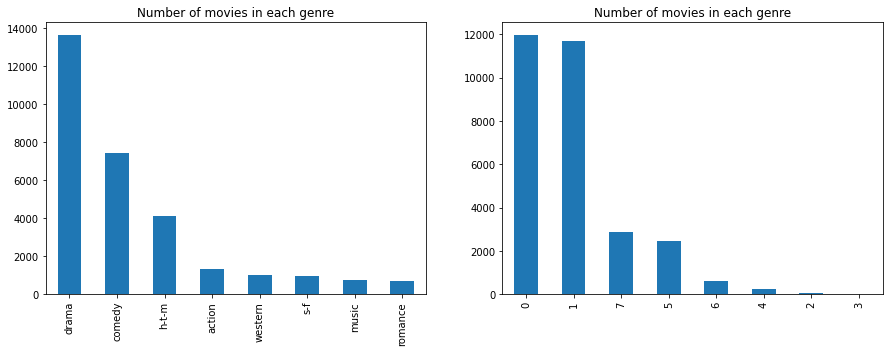

In [27]:
#plot both count plots of genre on top of each other
fig, ax = plt.subplots(1,2, figsize=(15,5))
data['genre'].value_counts().plot(kind='bar', title='Number of movies in each genre', ax=ax[0])
pd.Series(m.labels_).value_counts().plot(kind='bar', title='Number of movies in each genre', ax=ax[1])
plt.show()

In [28]:
y_sc_df = pd.DataFrame(m.labels_, columns=['genre'])
values_counts = pd.Series(m.labels_).value_counts()
values_counts

0    11952
1    11700
7     2864
5     2469
6      599
4      253
2       39
3       18
dtype: int64